# A priori SBMs
Comparing connectivity models generated from biological node metadata

In [1]:
from pkg.utils import set_warnings

set_warnings()

from itertools import chain, combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from graspologic.models import SBMEstimator
from graspologic.plot import adjplot
from graspologic.utils import binarize, remove_loops
from pkg.data import load_adjacency, load_networkx, load_node_meta, load_palette
from pkg.plot import set_theme
from pkg.io import savefig


def stashfig(name, **kwargs):
    savefig(name, foldername="a_priori_sbm", **kwargs)


def group_repr(group_keys):
    """Get a string representation of a list of group keys"""
    if len(group_keys) == 0:
        return "{}"
    elif len(group_keys) == 1:
        return str(group_keys[0])
    else:
        out = f"{group_keys[0]}"
        for key in group_keys[1:]:
            out += " x "
            out += key
        return out


def powerset(iterable, ignore_empty=True):
    # REF: https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset
    "powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(
        chain.from_iterable(combinations(s, r) for r in range(ignore_empty, len(s) + 1))
    )


def plot_upset_indicators(
    intersections,
    ax=None,
    facecolor="black",
    element_size=None,
    with_lines=True,
    horizontal=True,
    height_pad=0.7,
):
    # REF: https://github.com/jnothman/UpSetPlot/blob/e6f66883e980332452041cd1a6ba986d6d8d2ae5/upsetplot/plotting.py#L428
    """Plot the matrix of intersection indicators onto ax"""
    data = intersections
    n_cats = data.index.nlevels

    idx = np.flatnonzero(data.index.to_frame()[data.index.names].values)
    c = np.array(["lightgrey"] * len(data) * n_cats, dtype="O")
    c[idx] = facecolor
    x = np.repeat(np.arange(len(data)), n_cats)
    y = np.tile(np.arange(n_cats), len(data))
    if element_size is not None:
        s = (element_size * 0.35) ** 2
    else:
        # TODO: make s relative to colw
        s = 200
    ax.scatter(x, y, c=c.tolist(), linewidth=0, s=s)

    if with_lines:
        line_data = (
            pd.Series(y[idx], index=x[idx]).groupby(level=0).aggregate(["min", "max"])
        )
        ax.vlines(
            line_data.index.values,
            line_data["min"],
            line_data["max"],
            lw=2,
            colors=facecolor,
        )

    tick_axis = ax.yaxis
    tick_axis.set_ticks(np.arange(n_cats))
    tick_axis.set_ticklabels(data.index.names, rotation=0 if horizontal else -90)
    # ax.xaxis.set_visible(False)
    ax.tick_params(axis="both", which="both", length=0)
    if not horizontal:
        ax.yaxis.set_ticks_position("top")
    ax.set_frame_on(False)
    ax.set_ylim((-height_pad, n_cats - 1 + height_pad))


def upset_stripplot(data, x=None, y=None, ax=None, upset_ratio=0.3, **kwargs):
    divider = make_axes_locatable(ax)

    sns.stripplot(data=data, x=x, y=y, ax=ax, **kwargs)
    ax.set(xticks=[], xticklabels=[], xlabel="")

    upset_ax = divider.append_axes(
        "bottom", size=f"{upset_ratio*100}%", pad=0, sharex=ax
    )
    plot_upset_indicators(data, ax=upset_ax)
    upset_ax.set_xlabel("Grouping")
    return ax, upset_ax


palette = load_palette()
set_theme()

## Load the data

### Load node metadata and select the graph of interest

In [2]:
meta = load_node_meta()
meta = meta[meta["paper_clustered_neurons"]]

#%%[markdown]
# ### Create some new metadata columns from existing information

In [3]:
# make some new metadata columns
assert (
    meta[["ipsilateral_axon", "contralateral_axon", "bilateral_axon"]].sum(axis=1).max()
    == 1
)

meta["axon_lat"] = "other"
meta.loc[meta[meta["ipsilateral_axon"]].index, "axon_lat"] = "ipsi"
meta.loc[meta[meta["contralateral_axon"]].index, "axon_lat"] = "contra"
meta.loc[meta[meta["bilateral_axon"]].index, "axon_lat"] = "bi"

# TODO:
# io: input/"interneuron"/output
# probably others, need to think...

### Load the graph

In [4]:
g = load_networkx(graph_type="G", node_meta=meta)
adj = nx.to_numpy_array(g, nodelist=meta.index)
adj = binarize(adj)

## Fit a series of *a priori* SBMs
Here I use these known groupings of neurons to fit different *a priori* SBMs. As an
example, consider the groupings `hemisphere` and `axon_lat`. `hemisphere` indicates
whether a neuron is on the left, right, or center. `axon_lat` indicates whether a
neuron's axon is ipsilateral, bilateral, or contralateral. We could fit an SBM
using either of these groupings as our partition of the nodes, but we could also use
`hemisphere` *cross* `axon_lat` to get categories like `(left, ipsilateral)`,
`(left, contralateral)`, etc.

Below, I fit SBMs using a variety of these different groupings. I evaluate each model
in terms of log-likelihood, the number of parameters, and BIC.

In [5]:
single_group_keys = ["hemisphere", "simple_group", "lineage", "axon_lat"]
all_group_keys = powerset(single_group_keys, ignore_empty=False)

rows = []
for group_keys in all_group_keys:
    group_keys = list(group_keys)
    print(group_keys)

    if len(group_keys) > 0:
        # this is essentially just grabbing the labels that are group_key1 cross group_key2
        # etc. and then applying this as a column in the metadata
        groupby = meta.groupby(group_keys)
        groups = groupby.groups
        unique_group_keys = list(sorted(groups.keys()))
        group_map = dict(zip(unique_group_keys, range(len(unique_group_keys))))
        if len(group_keys) > 1:
            meta["_group"] = list(meta[group_keys].itertuples(index=False, name=None))
        else:
            meta["_group"] = meta[group_keys]
        meta["_group_id"] = meta["_group"].map(group_map)
    else:  # then this is the ER model...
        meta["_group_id"] = np.zeros(len(meta))

    # fitting the simple SBM
    Model = SBMEstimator
    estimator = Model(directed=True, loops=False)
    estimator.fit(adj, y=meta["_group_id"].values)

    # evaluating and saving results
    estimator.n_verts = len(adj)
    bic = estimator.bic(adj)
    lik = estimator.score(adj)
    n_params = estimator._n_parameters()
    penalty = 2 * np.log(len(adj)) * n_params
    row = {
        "bic": bic,
        "lik": lik,
        "group_keys": group_repr(group_keys),
        "n_params": n_params,
        "penalty": penalty,
    }
    for g in single_group_keys:
        if g in group_keys:
            row[g] = True
        else:
            row[g] = False
    rows.append(row)

[]
['hemisphere']
['simple_group']
['lineage']
['axon_lat']
['hemisphere', 'simple_group']
['hemisphere', 'lineage']
['hemisphere', 'axon_lat']
['simple_group', 'lineage']
['simple_group', 'axon_lat']
['lineage', 'axon_lat']
['hemisphere', 'simple_group', 'lineage']
['hemisphere', 'simple_group', 'axon_lat']
['hemisphere', 'lineage', 'axon_lat']
['simple_group', 'lineage', 'axon_lat']
['hemisphere', 'simple_group', 'lineage', 'axon_lat']


### Collect experimental results

In [6]:
results = pd.DataFrame(rows)
results.sort_values("bic", ascending=True, inplace=True)
results["rank"] = np.arange(len(results), 0, -1)
results = results.set_index(single_group_keys)

## Evaluate model fits

### Plot BIC, likelihood, and the number of parameters for each model

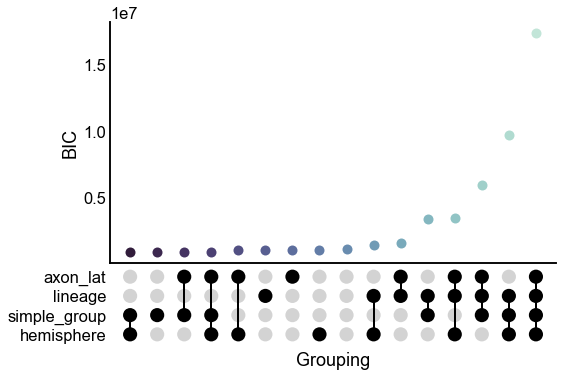

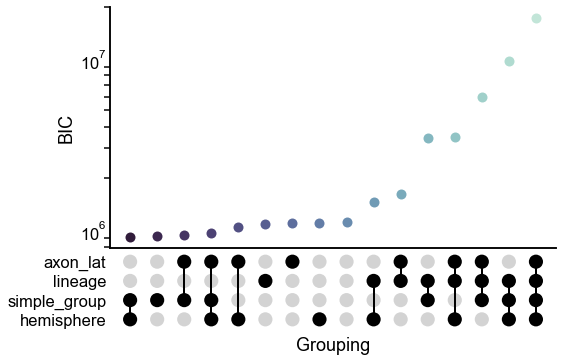

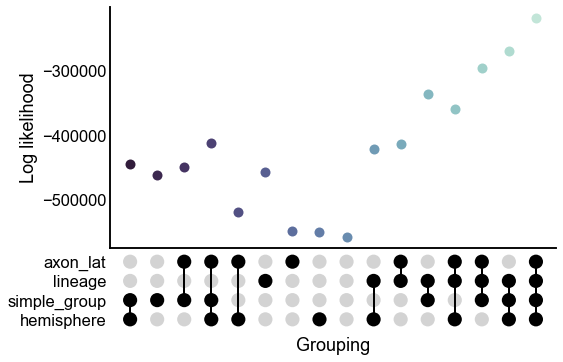

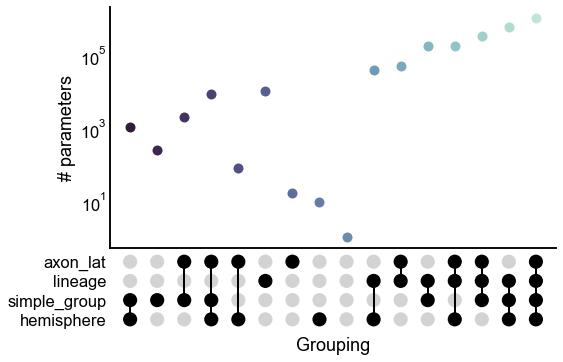

In [7]:
colors = sns.cubehelix_palette(
    start=0.5, rot=-0.5, n_colors=results["group_keys"].nunique()
)[::-1]
palette = dict(zip(results["group_keys"].unique(), colors))

stripplot_kws = dict(
    jitter=0,
    x="group_keys",
    s=10,
    palette=palette,
    upset_ratio=0.35,
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
upset_stripplot(results, y="bic", ax=ax, **stripplot_kws)
ax.set(ylabel="BIC")
stashfig("all-model-bic")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
upset_stripplot(results, y="bic", ax=ax, **stripplot_kws)
ax.set(ylabel="BIC")
ax.set_yscale("log")
stashfig("all-model-bic-logy")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
upset_stripplot(results, y="lik", ax=ax, **stripplot_kws)
ax.set(ylabel="Log likelihood")
stashfig("all-model-lik")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
upset_stripplot(results, y="n_params", ax=ax, **stripplot_kws)
ax.set(ylabel="# parameters")
ax.set_yscale("log")
stashfig("all-model-n_params")

### Look at the tradeoff between complexity and fit

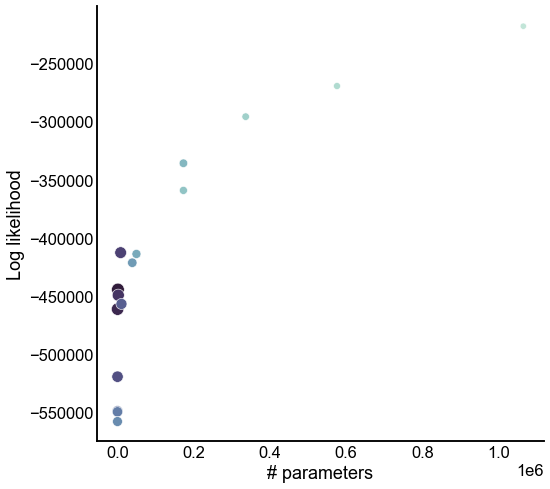

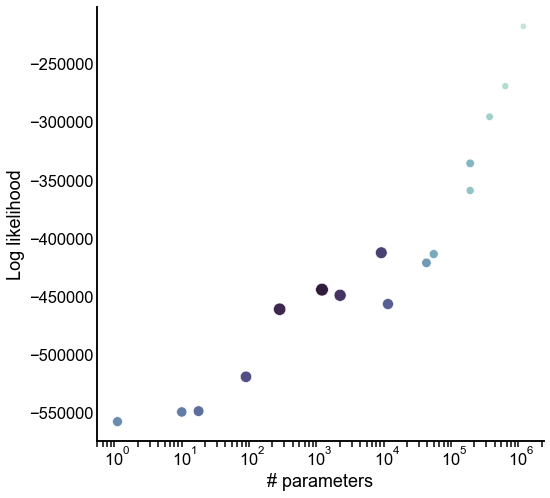

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=results,
    x="n_params",
    y="lik",
    hue="group_keys",
    palette=palette,
    legend=False,
    size="rank",
    ax=ax,
)
ax.set(xlabel="# parameters", ylabel="Log likelihood")
stashfig("all-model-n_params-vs-lik")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=results,
    x="n_params",
    y="lik",
    hue="group_keys",
    palette=palette,
    legend=False,
    size="rank",
    ax=ax,
)
ax.set(xlabel="# parameters", ylabel="Log likelihood")
ax.set_xscale("log")
stashfig("all-model-n_params-vs-lik-logx")